In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

from scipy import integrate
from tqdm.notebook import tqdm
from mpl_toolkits import mplot3d

In [2]:
class BDsystem():
    
        def __init__(self, Npart, Nsteps, box_size,  T_sig, fric_sig, k_z, k_sigma, save_freq):
            self.N = Npart
            self.steps = Nsteps
            self.save_freq = save_freq
            self.step_save = int(self.steps / self.save_freq)
            self.L = box_size
            self.eq_steps = 5000
            
            self.fric_x = 1
            self.T_x = 1
            self.T_sigma = T_sig
            self.fric_sigma = fric_sig        
            self.k = k_z
            self.k_sigma = k_sigma
            
            self.x0 = np.random.uniform(-self.L, self.L, size=self.N)
            self.sigma0 = np.random.normal(1, 0.2, size=self.N)
            for i in range (self.N):
                if self.sigma0[i] <= 0:
                    self.sigma0[i] = 1.0
    
            self.x = np.zeros((self.N, self.step_save))
            self.sigma = np.zeros((self.N, self.step_save))
            self.z = np.zeros((self.N, self.step_save))

        def BD_run(self, dt, lim): 
            # equilibration run
            for j in range (self.eq_steps - 1):
                self.__move(dt)
            
            n = 0
            for i in range (self.steps - 1):
                self.__move(dt)
                if (i % self.save_freq) == 0:
                    self.x[:, n] = self.x0
                    self.sigma[:, n] = self.sigma0
                    self.z[:, n] = self.x0 / self.sigma0
                    n += 1    
            self.Pz, self.Z = self.occ_prob(self.z, -lim[0], lim[0], N_bins)
            self.Px, self.X = self.occ_prob(self.x, -lim[1], lim[1], N_bins)
            self.Psigm, self.Sigm = self.occ_prob(self.sigma, -1, lim[2], N_bins)      
        
        def print_probabilities(self):
            return self.Z, self.Pz, self.X, self.Px, self.Sigm, self.Psigm
        
        def print_coord(self):
            return self.z, self.x, self.sigma
    
        def __move(self, dt):
            Rand1 = np.sqrt(2 * self.T_x * self.fric_x 
                                 * dt) * np.random.normal(0, 1, size=(self.N))
            Rand2 = np.sqrt(2 * self.T_sigma * self.fric_sigma 
                                 * dt) * np.random.normal(0, 1, size=(self.N))
            F_x = - self.k * dt * (self.x0 / self.sigma0**2)
            F_sigma = self.k * dt * (self.x0**2 / self.sigma0**3) - self.k_sigma * dt * (self.sigma0 - 1.0)
            
            self.x0 = self.x0 + (F_x + Rand1) / self.fric_x
            #self.x0 = ((self.x0 + box_size) % box_size) * np.sign(self.x0)
            sigma_old = self.sigma0
            self.sigma0 = self.sigma0 + (F_sigma + Rand2) / self.fric_sigma  
            for i in range (self.N):
                if self.sigma0[i] <= 0.05:
                    self.sigma0[i] = sigma_old[i]
            
        def occ_prob(self, values, left_lim, right_lim, N_bins):
            occup, Z = np.histogram(values, N_bins, (left_lim, right_lim))
            delta_z = (right_lim - left_lim) / N_bins
            norm = np.sum(occup) * delta_z
            Z = Z[:-1] + 0.5 * delta_z
            occnorm = occup / norm
            return occnorm, Z 
        
        def probZ_theory1(self, z):
            self.eff_temperature(z)
            self.force(z)
            delta_z = z[1] - z[0]
            y_integr = []
            integrand = []
            self.P_theory = np.zeros(np.size(z))
            for i in range (np.size(z)):
                y_integr.append(z[i])
                integrand.append(self.f[i] / self.Teff[i])
                integral = integrate.trapz(integrand, y_integr)
                self.P_theory[i] = np.exp(integral) / self.Teff[i]
            norm = np.sum(self.P_theory) * delta_z
            self.P_theory = self.P_theory / norm
            return self.P_theory   
        
        def probZ_theory2(self, z, sigma):
            self.eff_temperature(z)
            self.force(z)
            self.sigma_confinement_pot(sigma)
            delta_z = z[1] - z[0]
            delta_sigma = sigma[1] - sigma[0]
            y_integr = []
            integrand = []
            self.P_theory = np.zeros((np.size(z), np.size(sigma)))
            for i in range (np.size(z)):
                y_integr.append(z[i])
                integrand.append(self.f[i] / self.Teff[i])
                integral = integrate.trapz(integrand, y_integr)
                for j in range (np.size(sigma)):
                    self.P_theory[i, j] = np.exp(integral) * np.exp(- self.V_sigma[j] / self.T_sigma) / self.Teff[i]
            norm = np.sum(self.P_theory, axis=(0, 1)) * delta_z * delta_sigma 
            self.P_theory = self.P_theory / norm
            return self.P_theory  
        
        def eff_temperature(self, z):
            self.Teff  = (self.T_sigma * self.fric_x * z**2 + self.T_x * self.fric_sigma) / (self.fric_x * z**2 + 
                                                                                             self.fric_sigma)
        def print_eff_T(self):    
            return self.Teff
        
        def force(self, z):
            self.f = - self.k * z 
            
        def sigma_confinement_pot(self, sigma):
            self.V_sigma = 0.5 * self.k_sigma * sigma**2
            
        def p_low_fric1(self, z):
            self.Vz = self.harmonic_pot(z)
            delta_z = z[1] - z[0]
            P = np.exp(- self.Vz / self.T_sigma) / self.T_sigma
            norm = np.sum(P) * delta_z
            return P / norm     
            
        def p_high_fric1(self, z):
            self.Vz = self.harmonic_pot(z)
            delta_z = z[1] - z[0]
            P = np.exp(- self.Vz / self.T_x) / self.T_x 
            norm = np.sum(P) * delta_z
            return P / norm 
            
        def p_low_fric2(self, z, sigma):
            self.Vz = self.harmonic_pot(z)
            self.sigma_confinement_pot(sigma)
            delta_z = z[1] - z[0]
            delta_sigma = sigma[1] - sigma[0]
            P = np.zeros((np.size(z), np.size(sigma)))
            for j in range (np.size(sigma)):
                P[:, j] = np.exp(- self.Vz / self.T_sigma) * np.exp(- self.V_sigma[j] / self.T_sigma) / self.T_sigma
            norm = np.sum(P, axis=(0, 1)) * delta_z * delta_sigma
            return P / norm     
            
        def p_high_fric2(self, z, sigma):
            self.Vz = self.harmonic_pot(z)
            self.sigma_confinement_pot(sigma)
            delta_z = z[1] - z[0]
            delta_sigma = sigma[1] - sigma[0]
            P = np.zeros((np.size(z), np.size(sigma)))
            for j in range (np.size(sigma)):
                P[:, j] = np.exp(- self.Vz / self.T_x) * np.exp(- self.V_sigma[j] / self.T_sigma) / self.T_x 
            norm = np.sum(P, axis=(0, 1)) * delta_z * delta_sigma
            return P / norm 
        
        def harmonic_pot(self, z):
            return 0.5 * self.k * z**2 
        
        def prob_XSigma_theory(self, x, sigma):
            Pz1 = np.zeros((np.size(x), np.size(sigma)))
            Px = np.zeros(np.size(x))
            Psigma = np.zeros(np.size(sigma))
            for j in range (np.size(sigma)):
                z = x / sigma[j]
                Pz1[:, j] = self.probZ_theory1(z)
            Psigma = integrate.trapz(Pz, x, axis=0)
            Px = integrate.trapz(Pz, sigma, axis=1)           
            return Px, Psigma

In [3]:
def write_in_file(value, filename):
    f = open(filename, "a")
    f.write("Now the file has more content!")
    f.close()

In [4]:
plt.rcParams["font.family"] = "serif"
plt.rc('text', usetex=True)
plt.rcParams['text.latex.preamble'] = r"\usepackage{bm} \usepackage{amsmath}"

Numerical solution for $V = \frac{kz^2}{2}$:

In [5]:
N_part = 5000
N_steps = 10000
box_size = 10.0
Save_freq = 20
k = 1.0
dt = 0.0007

T_sigma = [0.1, 1.0, 10.0]
fric_sigma = [0.1, 1.0, 10.0]

lim = [6, 10, 40]
N_bins = 100
N_bin_th = 200

In [ ]:
Pz_num = np.zeros((np.size(T_sigma), np.size(fric_sigma), N_bins))
Px = np.zeros((np.size(T_sigma), np.size(fric_sigma), N_bins))
Psigma = np.zeros((np.size(T_sigma), np.size(fric_sigma), N_bins))

z_theory = np.linspace(-10.0, 10.0, N_bin_th)
sigma_theory = 1.0
Pz_theory = np.zeros((np.size(T_sigma), np.size(fric_sigma), N_bin_th))
P_smallfr1 = np.zeros((np.size(T_sigma), N_bin_th))
T_eff_th = np.zeros((np.size(T_sigma), np.size(fric_sigma), np.size(z_theory)))

for i in range (np.size(T_sigma)):
    for j in tqdm(range (np.size(fric_sigma))):
        random.seed(7 * i + j)
        p1 = BDsystem(N_part, N_steps, box_size,  T_sigma[i], fric_sigma[j], k, 0.0, Save_freq)
        p1.BD_run(dt, lim)
        
        z_bins, Pz_num[i, j, :], x_bins, Px[i, j, :], sigma_bins, Psigma[i, j, :] = p1.print_probabilities()
        
        Pz_theory[i, j, :] = p1.probZ_theory1(z_theory)
        T_eff_th[i, j, :] = p1.print_eff_T()
    P_smallfr1[i, :] = p1.p_low_fric1(z_theory)
P_bigfr = p1.p_high_fric1(z_theory)


In [ ]:
random.seed(7)
p1 = BDsystem(N_part, 5000, box_size,  T_sigma[1], fric_sigma[0], k, 0.0, 10)
p1.BD_run(dt, lim)
z_bins, Pz_num[1, 0, :], x_bins, Px[1, 0, :], sigma_bins, Psigma[1, 0, :] = p1.print_probabilities()

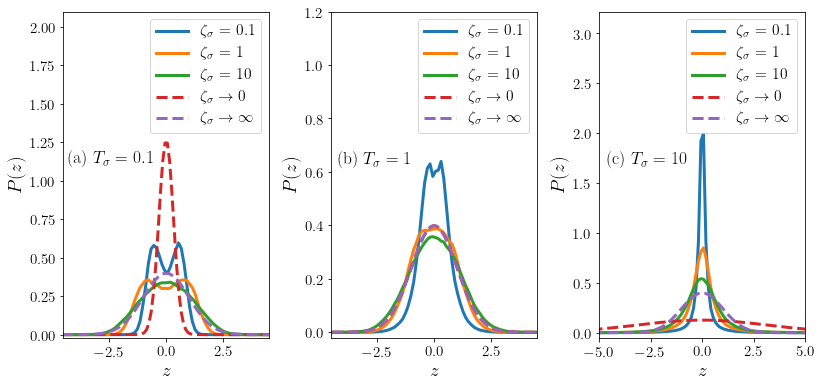

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(13.3, 6.0))
fig.subplots_adjust(wspace=0.3)

for i in range (np.size(T_sigma)):
    #for j in range (np.size(fric_sigma)):
    axs[i].plot(z_bins, Pz_num[i, 0, :], label=r'$\zeta_\sigma$ = {0}'.format(0.1), linewidth=3)
    axs[i].plot(z_bins, Pz_num[i, 1, :], label=r'$\zeta_\sigma$ = {0}'.format(1), linewidth=3)
    axs[i].plot(z_bins, Pz_num[i, 2, :], label=r'$\zeta_\sigma$ = {0}'.format(10), linewidth=3)
        
    axs[i].plot(z_theory, P_smallfr1[i, :], '--', label=r'$\zeta_\sigma \to 0$', linewidth=3)
    axs[i].plot(z_theory, P_bigfr, '--', label=r'$\zeta_\sigma \to \infty$', linewidth=3)

    axs[i].set_ylabel('$P(z)$', fontsize=19)
    axs[i].set_xlabel('$z$', fontsize=19)
    #axs[i].set_title(r'$T_\sigma$ = {0}'.format(T_sigma[i]), fontsize=17)
    axs[i].set_xlim(-4.5, 4.5)

    axs[i].tick_params(labelsize=15)
    axs[i].legend(fontsize=15.6)

axs[0].text(-4.3, 1.10, r'(a) $T_\sigma = 0.1$', fontsize=17.5)
axs[1].text(-4.2, 0.62, r'(b) $T_\sigma = 1$', fontsize=17.5)
axs[2].text(-4.6, 1.67, r'(c) $T_\sigma = 10$', fontsize=17.5)

axs[0].set_ylim(-0.02, 2.1)
axs[1].set_ylim(-0.02, 1.2)
axs[2].set_ylim(-0.05, 3.22)      
axs[2].set_xlim(-5, 5)
plt.savefig('Pz_num.pdf', bbox_inches='tight')
plt.show()     

In [ ]:
T_0_th = np.ones((np.size(z_theory)))
T_sigma_th = np.ones((np.size(T_sigma), np.size(z_theory)))   
T_sigma_th[0] = T_sigma[0] * np.ones((np.size(z_theory)))   
T_sigma_th[1] = T_sigma[1] * np.ones((np.size(z_theory)))  
T_sigma_th[2] = T_sigma[2] * np.ones((np.size(z_theory)))  

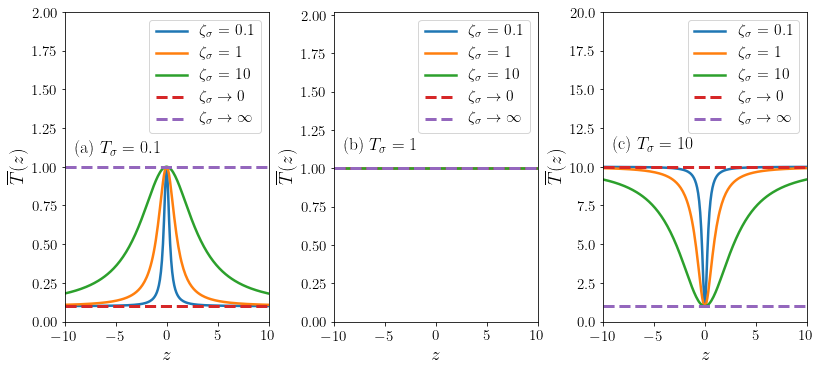

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(13.3, 5.7))
fig.subplots_adjust(wspace=0.32)

for i in range (np.size(T_sigma)):        
    axs[i].plot(z_theory, T_eff_th[i, 0, :], label=r'$\zeta_\sigma$ = 0.1', linewidth=2.5)
    axs[i].plot(z_theory, T_eff_th[i, 1, :], label=r'$\zeta_\sigma$ = 1', linewidth=2.5)
    axs[i].plot(z_theory, T_eff_th[i, 2, :], label=r'$\zeta_\sigma$ = 10', linewidth=2.5)
    
    axs[i].plot(z_theory, T_sigma_th[i], '--', label=r'$\zeta_\sigma \to 0$', linewidth=3)
    axs[i].plot(z_theory, T_0_th, '--', label=r'$\zeta_\sigma \to \infty$', linewidth=3)

    axs[i].set_ylabel(r'$\overline{T}(z)$', fontsize=19)
    axs[i].set_xlabel('$z$', fontsize=19)
    #axs[i].set_title(r'$T_\sigma$ = {0}'.format(T_sigma[i]), fontsize=17)
    axs[i].set_xlim(-10, 10)

    axs[i].tick_params(labelsize=15)
    axs[i].legend(fontsize=15.6)

axs[0].text(-9, 1.07, r'(a) $T_\sigma = 0.1$', fontsize=17.5)
axs[1].text(-9, 1.1, r'(b) $T_\sigma = 1$', fontsize=17.5)
axs[2].text(-9, 11, r'(c) $T_\sigma = 10$', fontsize=17.5)

axs[0].set_ylim(0.0, 2)
axs[1].set_ylim(0.0, 2.02)
axs[2].set_ylim(0.0, 20)      
plt.savefig('Teff_th.pdf', bbox_inches='tight')
plt.show()   

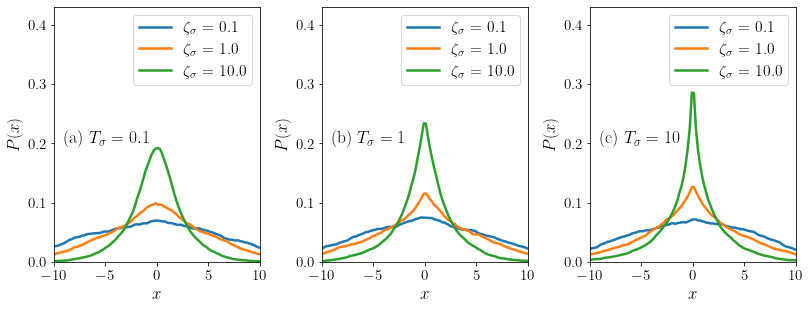

In [ ]:
fig, axs = plt.subplots(1, 3, sharex=True, figsize=(13.3, 4.7))
fig.subplots_adjust(wspace=0.3)

for i in range (np.size(T_sigma)):
    for j in range (np.size(fric_sigma)):
        axs[i].plot(x_bins, Px[i, j, :], label=r'$\zeta_\sigma$ = {0}'.format(fric_sigma[j]), linewidth=2.5)
        
    axs[i].set_ylabel('$P(x)$', fontsize=17)
    axs[i].set_xlabel('$x$', fontsize=17)
    #axs[i].set_title(r'$T_\sigma$ = {0}'.format(T_sigma[i]), fontsize=17)
    axs[i].set_xlim(-10, 10)
    axs[i].set_ylim(-0.001, 0.43)
    axs[i].tick_params(labelsize=15)
    axs[i].legend(fontsize=15.6)
    
axs[0].text(-9, 0.20, r'(a) $T_\sigma = 0.1$', fontsize=17.5)
axs[1].text(-9, 0.2, r'(b) $T_\sigma = 1$', fontsize=17.5)
axs[2].text(-9, 0.2, r'(c) $T_\sigma = 10$', fontsize=17.5)
       
plt.savefig('Px_num.pdf', bbox_inches='tight')
plt.show()  

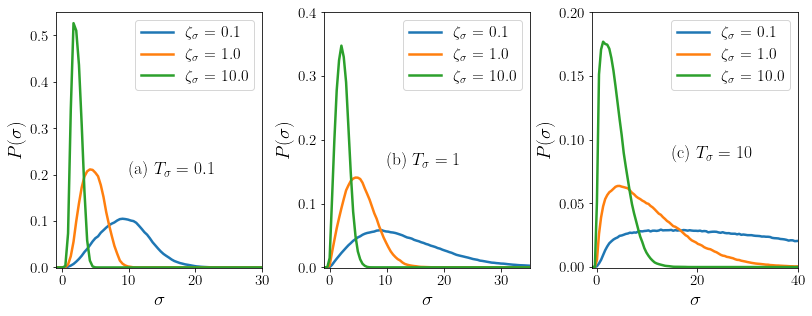

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(13.3, 4.7))
fig.subplots_adjust(wspace=0.3)

for i in range (np.size(T_sigma)):
    for j in range (np.size(fric_sigma)):
        axs[i].plot(sigma_bins, Psigma[i, j, :], label=r'$\zeta_\sigma$ = {0}'.format(fric_sigma[j]), linewidth=2.5)

    axs[i].set_ylabel(r'$P(\sigma)$', fontsize=19)
    axs[i].set_xlabel(r'$\sigma$', fontsize=19)
    #axs[i].set_title(r'$T_\sigma$ = {0}'.format(T_sigma[i]), fontsize=17)
    
    
    axs[i].tick_params(labelsize=15)
    axs[i].legend(fontsize=15.6)
        

axs[0].text(10, 0.20, r'(a) $T_\sigma = 0.1$', fontsize=17.5)
axs[1].text(10, 0.16, r'(b) $T_\sigma = 1$', fontsize=17.5)
axs[2].text(15, 0.085, r'(c) $T_\sigma = 10$', fontsize=17.5)

axs[0].set_xlim(-1, 30)
axs[1].set_xlim(-1, 35)
axs[2].set_xlim(-1, 40)

axs[0].set_ylim(-0.0005, 0.55)
axs[1].set_ylim(-0.0005, 0.4)
axs[2].set_ylim(-0.0005, 0.2)
plt.savefig('Psigma_num.pdf', bbox_inches='tight')
plt.show()  

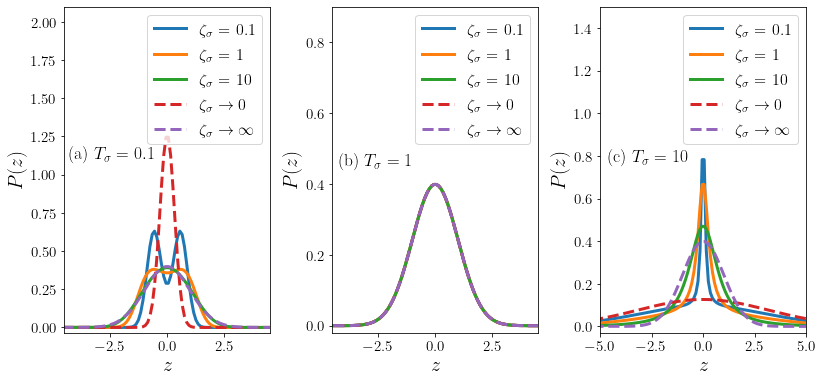

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(13.3, 6.0))
fig.subplots_adjust(wspace=0.3)

for i in range (np.size(T_sigma)):
    #for j in range (np.size(fric_sigma)):
    axs[i].plot(z_theory, Pz_theory[i, 0, :], label=r'$\zeta_\sigma$ = {0}'.format(0.1), linewidth=3)
    axs[i].plot(z_theory, Pz_theory[i, 1, :], label=r'$\zeta_\sigma$ = {0}'.format(1), linewidth=3)
    axs[i].plot(z_theory, Pz_theory[i, 2, :], label=r'$\zeta_\sigma$ = {0}'.format(10), linewidth=3)
    axs[i].plot(z_theory, P_smallfr1[i, :], '--', label=r'$\zeta_\sigma \to 0$', linewidth=3)
    axs[i].plot(z_theory, P_bigfr, '--', label=r'$\zeta_\sigma \to \infty$', linewidth=3)
        
    axs[i].set_ylabel('$P(z)$', fontsize=20)
    axs[i].set_xlabel('$z$', fontsize=20)
    #axs[i].set_title(r'$T_\sigma$ = {0}'.format(T_sigma[i]), fontsize=17)
    axs[i].set_xlim(-4.5, 4.5)
    axs[i].set_ylim(-0.01, 2)
    axs[i].tick_params(labelsize=15)
    axs[i].legend(fontsize=16.1)

axs[0].text(-4.3, 1.10, r'(a) $T_\sigma = 0.1$', fontsize=17.5)
axs[1].text(-4.2, 0.45, r'(b) $T_\sigma = 1$', fontsize=17.5)
axs[2].text(-4.6, 0.77, r'(c) $T_\sigma = 10$', fontsize=17.5)

axs[0].set_ylim(-0.035, 2.1)
axs[1].set_ylim(-0.02, 0.9)
axs[2].set_ylim(-0.03, 1.5)      
axs[2].set_xlim(-5, 5)
plt.savefig('Pz_theory.pdf', bbox_inches='tight')
plt.show()

## With $\sigma$ confinement

In [ ]:
k_sig = 3.0

Pz_num2 = np.zeros((np.size(T_sigma), np.size(fric_sigma), N_bins))
Px2 = np.zeros((np.size(T_sigma), np.size(fric_sigma), N_bins))
Psigma2 = np.zeros((np.size(T_sigma), np.size(fric_sigma), N_bins))

z_theory2 = np.linspace(-10.0, 10.0, N_bin_th)
sigma_theory2 = np.linspace(0.1, 10.0, 100)
Pz_theory2 = np.zeros((np.size(T_sigma), np.size(fric_sigma), N_bin_th, np.size(sigma_theory2)))
P_smallfr2 = np.zeros((np.size(T_sigma), N_bin_th, np.size(sigma_theory2)))

lim2 = [6, 10, 10]

for i in range (np.size(T_sigma)):
    for j in tqdm(range (np.size(fric_sigma))):
        random.seed(7 * i + j)
        p2 = BDsystem(N_part, N_steps, box_size, T_sigma[i], fric_sigma[j], k, k_sig, Save_freq)
        p2.BD_run(dt, lim2)
        z_bins, Pz_num2[i, j, :], x_bins, Px2[i, j, :], sigma_bins, Psigma2[i, j, :] = p2.print_probabilities()
        
        Pz_theory2[i, j, :, :] = p2.probZ_theory2(z_theory2, sigma_theory2)
    P_smallfr2[i, :, :] = p2.p_low_fric2(z_theory2, sigma_theory2)
P_bigfr2 = p2.p_high_fric2(z_theory2, sigma_theory2)

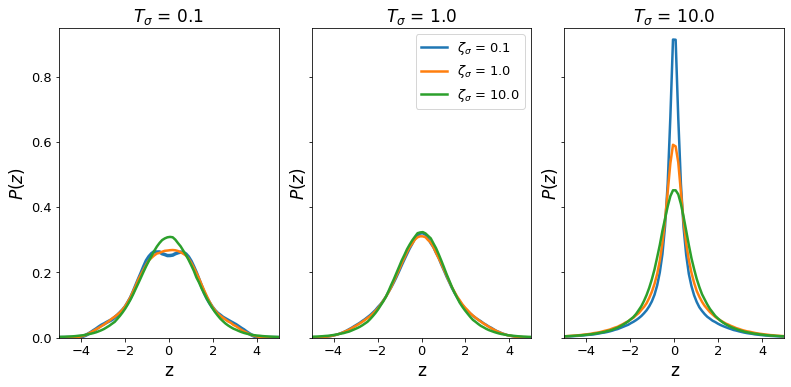

In [ ]:
fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(13, 5.7))
fig.subplots_adjust(wspace=0.15)

for i in range (np.size(T_sigma)):
    for j in range (np.size(fric_sigma)):
        if j == 0 and i == 0:
            lin_wid = 3.5
        else:
            lin_wid = 2.5    
        axs[i].plot(z_bins, Pz_num2[i, j, :], label=r'$\zeta_\sigma$ = {0}'.format(fric_sigma[j]), linewidth=lin_wid)
        
    axs[i].set_ylabel('$P(z)$', fontsize=17)
    axs[i].set_xlabel('z', fontsize=17)
    axs[i].set_title(r'$T_\sigma$ = {0}'.format(T_sigma[i]), fontsize=17)
    axs[i].set_xlim(-5, 5)
    axs[i].set_ylim(-0.0005, 0.95)
    axs[i].tick_params(labelsize=13)
        
axs[1].legend(fontsize=13)
plt.show() 

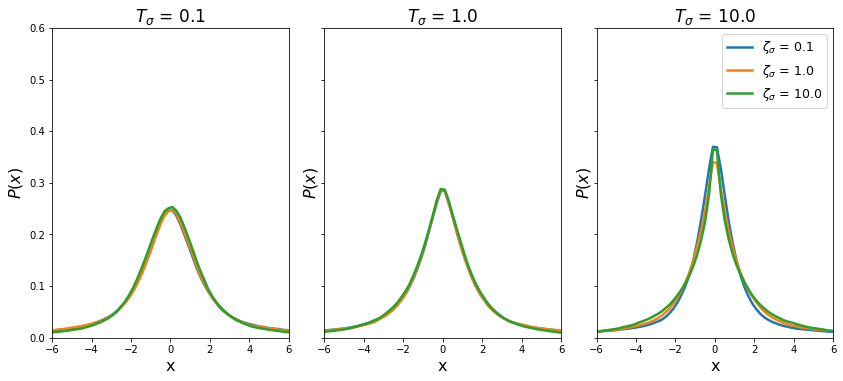

In [ ]:
fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(14, 5.7))
fig.subplots_adjust(wspace=0.15)

for i in range (np.size(T_sigma)):
    for j in range (np.size(fric_sigma)):
        axs[i].plot(x_bins, Px2[i, j, :], label=r'$\zeta_\sigma$ = {0}'.format(fric_sigma[j]), linewidth=2.5)
        
    axs[i].set_ylabel('$P(x)$', fontsize=16)
    axs[i].set_xlabel('x', fontsize=16)
    axs[i].set_title(r'$T_\sigma$ = {0}'.format(T_sigma[i]), fontsize=17)
    axs[i].set_xlim(-6, 6)
    axs[i].set_ylim(-0.0005, 0.6)
        
axs[2].legend(fontsize=12.5)
plt.show()

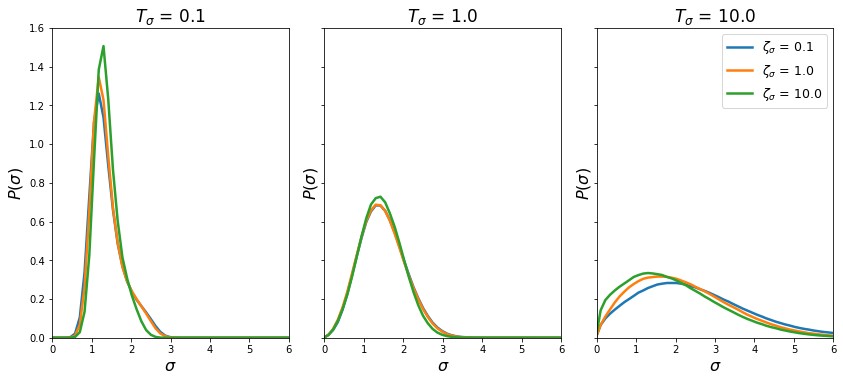

In [ ]:
fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(14, 5.7))
fig.subplots_adjust(wspace=0.15)

for i in range (np.size(T_sigma)):
    for j in range (np.size(fric_sigma)):
        axs[i].plot(sigma_bins, Psigma2[i, j, :], label=r'$\zeta_\sigma$ = {0}'.format(fric_sigma[j]), linewidth=2.5)
    axs[i].set_ylabel('$P(\sigma)$', fontsize=16)
    axs[i].set_xlabel('$\sigma$', fontsize=16)
    axs[i].set_title(r'$T_\sigma$ = {0}'.format(T_sigma[i]), fontsize=17)
    axs[i].set_xlim(-0, 6)
    axs[i].set_ylim(-0.0005, 1.6)
        
axs[2].legend(fontsize=12.5)
plt.show()

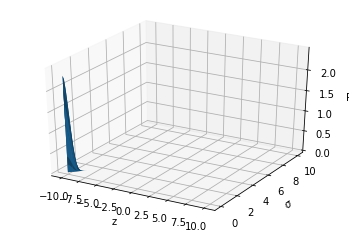

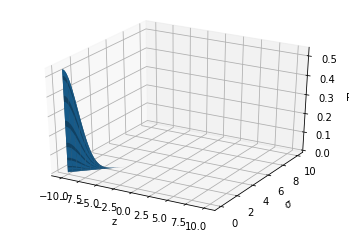

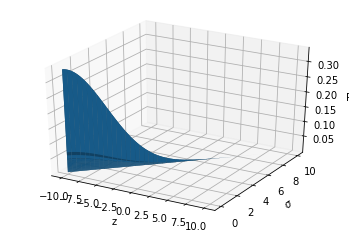

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(z_theory2, sigma_theory2, Pz_theory2[0, 0, :, :])
#ax.set_xlim(-10, -8)
#ax.set_ylim(0, 2)
ax.set_xlabel('z')
ax.set_ylabel('$\sigma$')
ax.set_zlabel('P')
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(z_theory2, sigma_theory2, Pz_theory2[1, 0, :, :])
#ax.set_xlim(-10, -8)
#ax.set_ylim(0, 2)
ax.set_xlabel('z')
ax.set_ylabel('$\sigma$')
ax.set_zlabel('P')
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(z_theory2, sigma_theory2, Pz_theory2[2, 0, :, :])
#ax.set_xlim(-10, -8)
#ax.set_ylim(0, 2)
ax.set_xlabel('z')
ax.set_ylabel('$\sigma$')
ax.set_zlabel('P')
plt.show()

In [ ]:
z_theory2 = np.linspace(-10.0, 10.0, N_bin_th)
sigma_theory2 = np.linspace(0.0, 10.0, 500)
Pz_theory2 = np.zeros((np.size(T_sigma), np.size(fric_sigma), N_bin_th, np.size(sigma_theory2)))
P_smallfr2 = np.zeros((np.size(T_sigma), N_bin_th, np.size(sigma_theory2)))
k_sig = 3.0

for i in range (np.size(T_sigma)):
    for j in tqdm(range (np.size(fric_sigma))):
        random.seed(7 * i + j)
        p2 = BDsystem(N_part, N_steps, box_size, T_sigma[i], fric_sigma[j], k, k_sig, Save_freq)
        Pz_theory2[i, j, :, :] = p2.prob_theory2(z_theory2, sigma_theory2)
    P_smallfr2[i, :, :] = p2.p_low_fric2(z_theory2, sigma_theory2)
P_bigfr2 = p2.p_high_fric2(z_theory2, sigma_theory2)

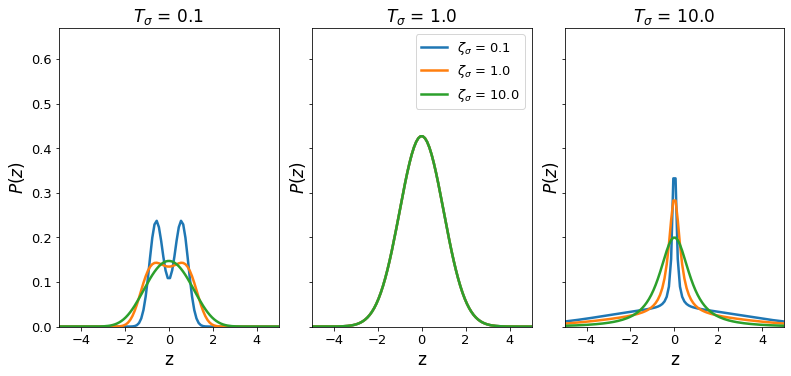

In [ ]:
fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(13, 5.5))
fig.subplots_adjust(wspace=0.15)

for i in range (np.size(T_sigma)):
    for j in range (np.size(fric_sigma)):
        axs[i].plot(z_theory2, Pz_theory2[i, j, :, 20], label=r'$\zeta_\sigma$ = {0}'.format(fric_sigma[j]), linewidth=2.5)
        
    axs[i].set_ylabel('$P(z)$', fontsize=17)
    axs[i].set_xlabel('z', fontsize=17)
    axs[i].set_title(r'$T_\sigma$ = {0}'.format(T_sigma[i]), fontsize=17)
    axs[i].set_xlim(-5, 5)
    axs[i].set_ylim(-0.0005, 0.67)
    axs[i].tick_params(labelsize=13)
        
axs[1].legend(fontsize=13)
plt.show() 